# Batch Normalization
---

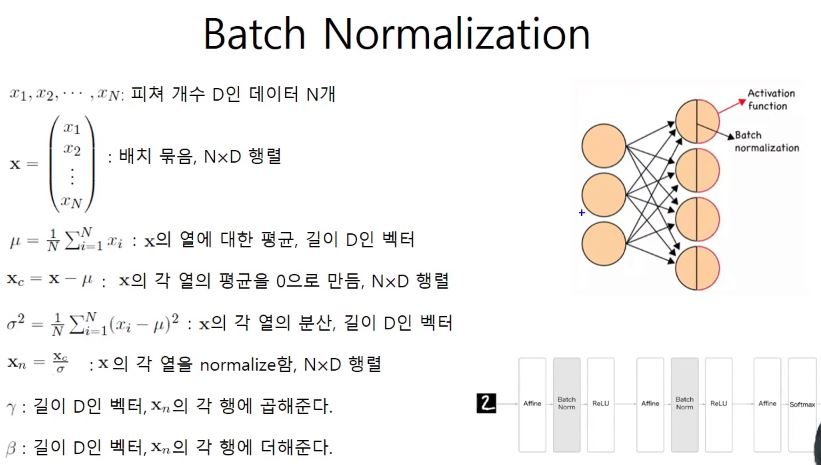

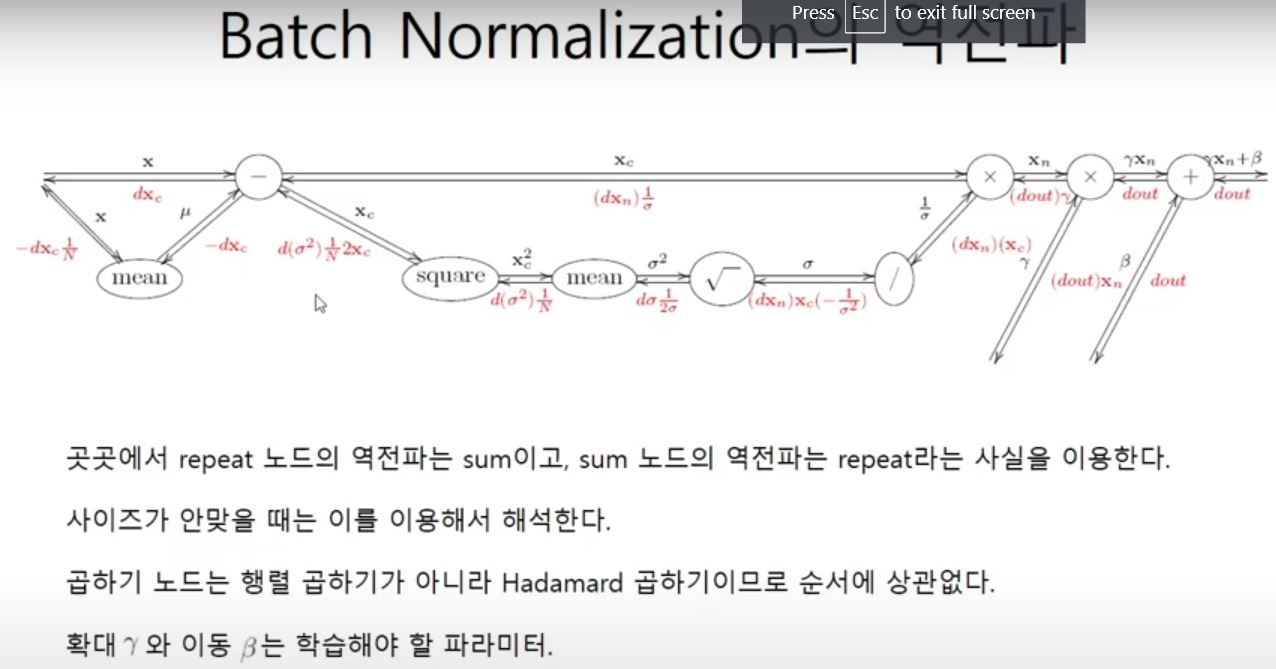

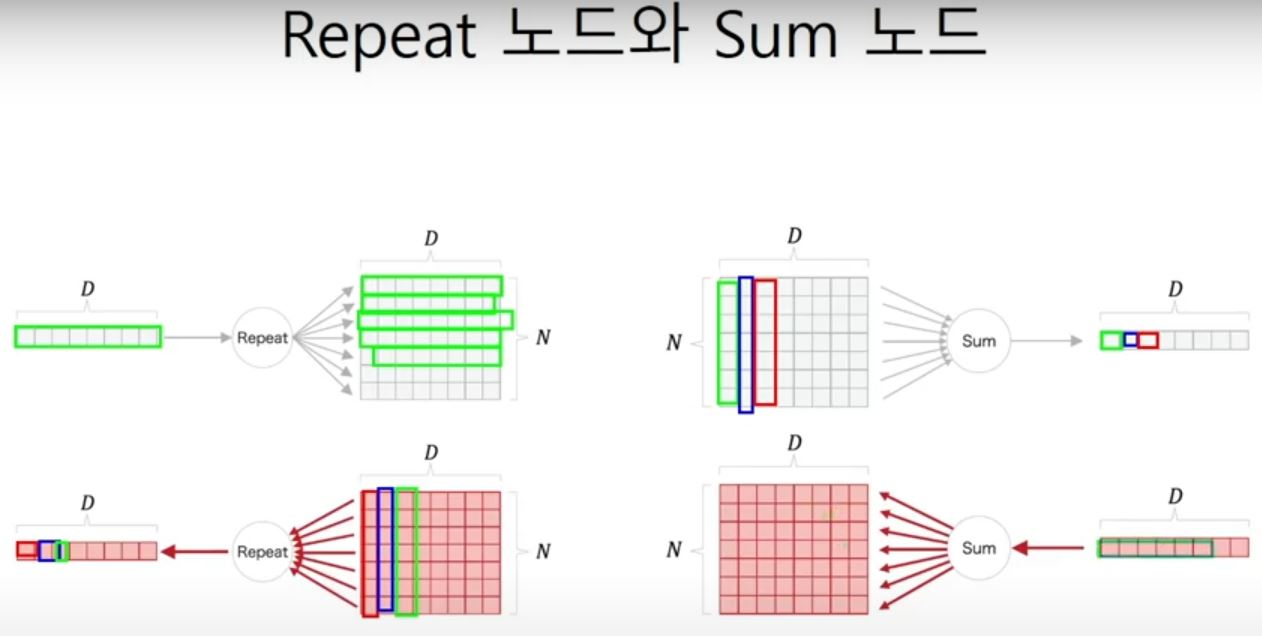

In [1]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum = 0.9,
                 running_mean = None, running_var = None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # CNN: 4-dimensional, FCL: 2-dimensional
        
        # for back prop
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None
        
        # for test (validation)
        self.running_mean = running_mean
        self.running_var = running_var
        
    def forward(self, x, train_flg = True):
        self.input_shape = x.shape
        if x.ndim != 2: # in case of CNN
            N, C, H, W = x.shape
            x = x.reshape(N, -1)
            
        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape) # Restore the original shape.
    
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
            
        if train_flg: # training
            mu = x.mean(axis = 0)
            xc = x - mu
            var = np.mean(xc**2, axis = 0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            # Why do running_mean and running_var appear in forward
            # but not in backward?
            self.running_mean = self.momentum * self.running_mean +\
            (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var +\
            (1 - self.momentum) * var
        else: # validation
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta
        
        return out
    
    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
            
        dx = self.__backward(dout)
        dx = dx.reshape(*self.input_shape)
        
        return dx
    
    def __backward(self, dout): # If repeat node, sum!!!
        dbeta = dout.sum(axis = 0)
        dgamma = np.sum(self.xn * dout, axis = 0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis = 0)
        dvar = 0.5 * dstd / self.std
        dvar /= self.batch_size # mean node
        dxc += dvar * (2.0 * self.xc)
        dmu = -np.sum(dxc, axis = 0)
        dx = dxc + (dmu / self.batch_size) # the 2nd factor: mean node
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

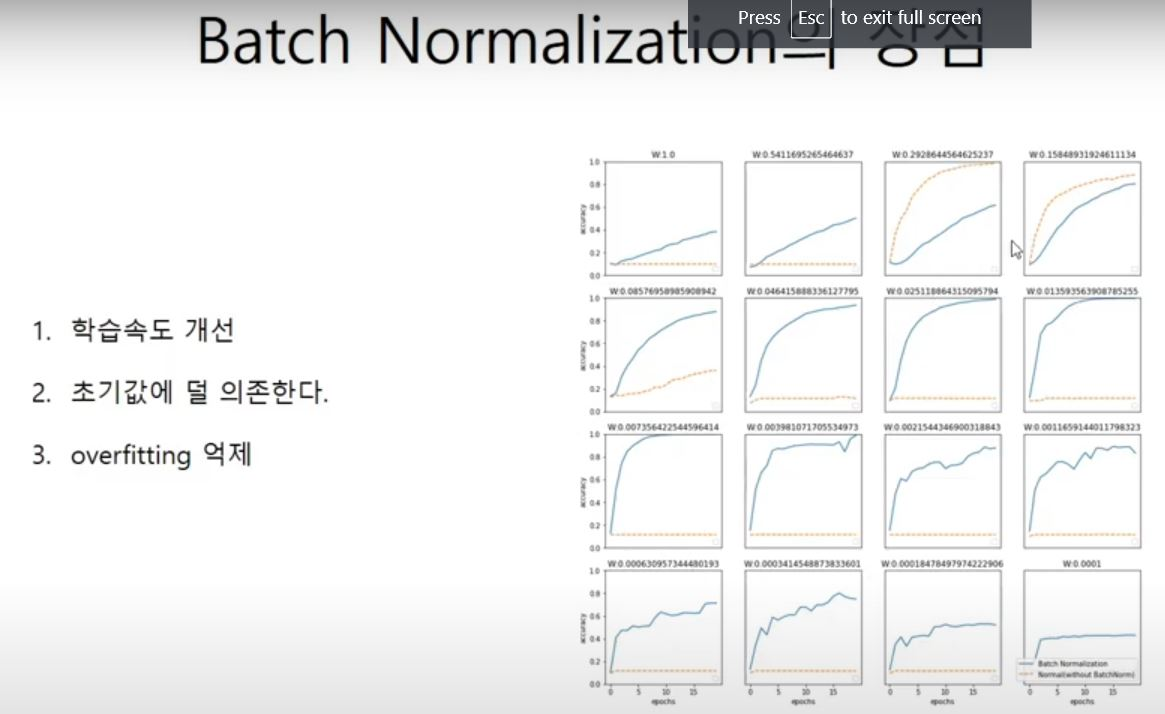

# Batch Normalization and Training Performance
---

In [2]:
import numpy as np
from collections import OrderedDict
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [3]:
# necessary functions and classes
class SGD:
    """
    stochastic gradient descent
    lr: learning rate hyperparameter
    """
    
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Adam:
    """
    Adam Optimizer
    lr: a learning rate component (eta in the above)
    beta1: a hyperparameter for the Momentum Part
    beta2: a hyperparameter for the RMSProp Part (varying learning rate)
    """
    
    def __init__(self, lr = 0.001, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
        self.iter += 1
        # modified learning rate (to replace m and v with m_hat and v_hat)
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / \
            (1.0 - self.beta1**self.iter)
        for key in params.keys():
            # Update the Momentum hyperparameter.
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            # Update the RMSProp hyperparameter.
            # Hadamard product can be easily implemented via NumPy operations.
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis = 0)
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        
        return y.T 

    x = x - np.max(x) # preventing overflow
    
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # Convert into groundtruth labels if training data are one-hot encoded.
    if t.size == y.size:
        t = t.argmax(axis = 1)
             
    batch_size = y.shape[0]
    
    return -np.sum(np.log(
        y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # gradients
        self.dW = None
        self.db = None

    def forward(self, x):
        # for tensor operations
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        # for tensor operations
        dx = dx.reshape(*self.original_x_shape)
        
        return dx

class SoftMaxWithLoss:
    def __init__(self):
        self.loss = None # loss function
        self.y = None    # SoftMax output
        self.t = None    # groundtruth (one-hot encoded)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # if one-hot encoded groundtruth
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags = ['multi_index'], op_flags = ['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x + h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x - h)
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        
        x[idx] = tmp_val # Restore values.
        it.iternext()   
        
    return grad
    
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask    

class MultiLayerNetExtend:
    """ Fully Connected Layer
    Parameters
    ----------
    input_size : 784 if MNIST
    hidden_size_list : the number of neurons in a hidden layer（e.g. [100, 100, 100]）
    output_size : 10 if MNIST
    activation : 'ReLU' or 'Sigmoid'
    weight_init_std : e.g. 0.01
        'ReLU' or 'He' -> Set He Initialization.
        'Sigmoid' or 'Xavier' -> Set Xavier Initialization.
    weight_decay_lambda : regularization parameter
    use_dropout : True or False
    dropout_ratio : Dropout Ratio
    use_batchNorm : True or False
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation = 'ReLU', weight_init_std = 'ReLU',
                 weight_decay_lambda = 0, use_dropout = False,
                 dropout_ratio = 0.5, use_batchnorm = False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # weight initialization
        self.__init_weight(weight_init_std)

        # the order of layers: Affine + Batch Norm + Activation + Dropout
        # creating hidden layers (Affine + activation per hidden layer)
        activation_layer = {'Sigmoid': Sigmoid, 'ReLU': ReLU}
        self.layers = OrderedDict()
        
        # input layer and hidden layers
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(
                self.params['W' + str(idx)],
                self.params['b' + str(idx)])
            
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(
                    hidden_size_list[idx -1])
                self.params['beta' + str(idx)] = np.zeros(
                    hidden_size_list[idx - 1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(
                    self.params['gamma' + str(idx)],
                    self.params['beta' + str(idx)])
            
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        # the output layer's Affine
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(
            self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        # cross entropy (not SoftMax function)
        self.last_layer = SoftMaxWithLoss()

    def __init_weight(self, weight_init_std):
        """
        Weight Initialization Parameters
        ----------
        weight_init_std : e.g. 0.01
            'ReLU' or 'He' -> Set He Initialization.
            'Sigmoid' or 'Xavier' -> Set Xavier Initialization.
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        # range: We do not need to consider the output layer's
        # weight initialization.
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                # recommended if ReLU
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                # recommended if Sigmoid
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            self.params['W' + str(idx)] = scale * np.random.randn(
                all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg = False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                # You need to additionally apply a SoftMax function
                # to get predicted values.
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg = False):
        y = self.predict(x, train_flg)

#         weight_decay = 0
#         # self.hidden_layer_num + 2: hidden layers
#         # + (input layer + output layer)
#         for idx in range(1, self.hidden_layer_num + 2):
#             W = self.params['W' + str(idx)]
#             weight_decay += 0.5 * self.weight_decay_lambda *\
#             np.sum(W ** 2)

        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, train_flg = False)
        y = np.argmax(y, axis = 1)
        # unless one-hot encoded groundtruth
        # ex) one-hot encoded: t = [[0, 0, 1, 0, ..., 0],
        #                           [1, 0, 0, 0, ..., 0],
        #                           [0, 1, 0, 0, ..., 0]] -> t.ndim = 2
        # ex) not one-hot encoded: t = [2, 0, 1] -> t.ndim = 1
        if t.ndim != 1: t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t, train_flg = True)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = numerical_gradient(
                loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(
                loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = numerical_gradient(
                    loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(
                    loss_W, self.params['beta' + str(idx)])

        return grads

    # back propagation
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg = True)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # Store results.
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            # L2-Regularization assumed (differentiated by weights)
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW +\
            self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

In [4]:
# input data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train[:1000].reshape(1000, -1)
t_train = t_train[:1000]
x_test = x_test.reshape(-1, 784)

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

In [5]:
def __train(weight_init_std):
    # network w/ batch normalization
    bn_network = MultiLayerNetExtend(input_size = 784,
                                     hidden_size_list = [100, 100, 100, 100, 100],
                                     output_size = 10,
                                     weight_init_std = weight_init_std,
                                     use_batchnorm = True)
    # network w/o batch normalization
    network = MultiLayerNetExtend(input_size = 784,
                                  hidden_size_list = [100, 100, 100, 100, 100],
                                  output_size = 10,
                                  weight_init_std = weight_init_std,
                                  use_batchnorm = False)
    optimizer = SGD(lr = learning_rate)
    
    bn_train_acc_list = []
    train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
        
        if i % iter_per_epoch == 0:
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc_list.append(bn_train_acc)
            train_acc_list.append(train_acc)
            
            print("Epoch:\t" + str(epoch_cnt + 1) + "\t| " +\
                 str(round(train_acc, 3)) + " - " +\
                 str(round(bn_train_acc, 3)))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

Optimizer: SGD

========== 1/16 ==========
Epoch:	1	| 0.099 - 0.133
Epoch:	2	| 0.097 - 0.165
Epoch:	3	| 0.097 - 0.159
Epoch:	4	| 0.097 - 0.185
Epoch:	5	| 0.097 - 0.216
Epoch:	6	| 0.097 - 0.233
Epoch:	7	| 0.097 - 0.254
Epoch:	8	| 0.097 - 0.273
Epoch:	9	| 0.097 - 0.291
Epoch:	10	| 0.097 - 0.314
Epoch:	11	| 0.097 - 0.334
Epoch:	12	| 0.097 - 0.349
Epoch:	13	| 0.097 - 0.371
Epoch:	14	| 0.097 - 0.384
Epoch:	15	| 0.097 - 0.402
Epoch:	16	| 0.097 - 0.412
Epoch:	17	| 0.097 - 0.421
Epoch:	18	| 0.097 - 0.434


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.097 - 0.455
Epoch:	20	| 0.097 - 0.469
========== 2/16 ==========
Epoch:	1	| 0.099 - 0.099


C:\Users\1suof\AppData\Local\Temp\ipykernel_23960\2388093910.py:53: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis = 0)


Epoch:	2	| 0.097 - 0.11
Epoch:	3	| 0.097 - 0.127
Epoch:	4	| 0.097 - 0.137
Epoch:	5	| 0.097 - 0.163
Epoch:	6	| 0.097 - 0.182
Epoch:	7	| 0.097 - 0.212
Epoch:	8	| 0.097 - 0.239
Epoch:	9	| 0.097 - 0.282
Epoch:	10	| 0.097 - 0.325
Epoch:	11	| 0.097 - 0.342
Epoch:	12	| 0.097 - 0.372
Epoch:	13	| 0.097 - 0.393
Epoch:	14	| 0.097 - 0.413
Epoch:	15	| 0.097 - 0.436
Epoch:	16	| 0.097 - 0.461
Epoch:	17	| 0.097 - 0.472
Epoch:	18	| 0.097 - 0.493
Epoch:	19	| 0.097 - 0.502


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.097 - 0.514
========== 3/16 ==========
Epoch:	1	| 0.117 - 0.095
Epoch:	2	| 0.097 - 0.095
Epoch:	3	| 0.097 - 0.141
Epoch:	4	| 0.097 - 0.191
Epoch:	5	| 0.097 - 0.229
Epoch:	6	| 0.097 - 0.257
Epoch:	7	| 0.097 - 0.303
Epoch:	8	| 0.097 - 0.33
Epoch:	9	| 0.097 - 0.36
Epoch:	10	| 0.097 - 0.386
Epoch:	11	| 0.097 - 0.412
Epoch:	12	| 0.097 - 0.442
Epoch:	13	| 0.097 - 0.467
Epoch:	14	| 0.097 - 0.488
Epoch:	15	| 0.097 - 0.504
Epoch:	16	| 0.097 - 0.522
Epoch:	17	| 0.097 - 0.546
Epoch:	18	| 0.097 - 0.569
Epoch:	19	| 0.097 - 0.588


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.097 - 0.605
========== 4/16 ==========
Epoch:	1	| 0.117 - 0.093
Epoch:	2	| 0.097 - 0.135


C:\Users\1suof\AppData\Local\Temp\ipykernel_23960\2388093910.py:53: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis = 0)


Epoch:	3	| 0.097 - 0.234
Epoch:	4	| 0.097 - 0.323
Epoch:	5	| 0.097 - 0.373
Epoch:	6	| 0.097 - 0.426
Epoch:	7	| 0.097 - 0.47
Epoch:	8	| 0.097 - 0.516
Epoch:	9	| 0.097 - 0.559
Epoch:	10	| 0.097 - 0.584
Epoch:	11	| 0.097 - 0.602
Epoch:	12	| 0.097 - 0.63
Epoch:	13	| 0.097 - 0.655
Epoch:	14	| 0.097 - 0.681
Epoch:	15	| 0.097 - 0.699
Epoch:	16	| 0.097 - 0.714
Epoch:	17	| 0.097 - 0.741
Epoch:	18	| 0.097 - 0.751


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.097 - 0.767
Epoch:	20	| 0.097 - 0.786
========== 5/16 ==========
Epoch:	1	| 0.12 - 0.114
Epoch:	2	| 0.348 - 0.143
Epoch:	3	| 0.535 - 0.263
Epoch:	4	| 0.632 - 0.393
Epoch:	5	| 0.745 - 0.502
Epoch:	6	| 0.79 - 0.562
Epoch:	7	| 0.834 - 0.623
Epoch:	8	| 0.853 - 0.677
Epoch:	9	| 0.895 - 0.707
Epoch:	10	| 0.911 - 0.733
Epoch:	11	| 0.942 - 0.761
Epoch:	12	| 0.95 - 0.777
Epoch:	13	| 0.966 - 0.787
Epoch:	14	| 0.981 - 0.805
Epoch:	15	| 0.988 - 0.825
Epoch:	16	| 0.991 - 0.84
Epoch:	17	| 0.99 - 0.851
Epoch:	18	| 0.996 - 0.861
Epoch:	19	| 0.997 - 0.867


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.998 - 0.874
========== 6/16 ==========
Epoch:	1	| 0.11 - 0.148
Epoch:	2	| 0.262 - 0.238
Epoch:	3	| 0.356 - 0.475
Epoch:	4	| 0.578 - 0.611
Epoch:	5	| 0.482 - 0.678
Epoch:	6	| 0.676 - 0.731
Epoch:	7	| 0.715 - 0.754
Epoch:	8	| 0.803 - 0.785
Epoch:	9	| 0.774 - 0.812
Epoch:	10	| 0.878 - 0.83
Epoch:	11	| 0.861 - 0.846
Epoch:	12	| 0.897 - 0.868
Epoch:	13	| 0.897 - 0.878
Epoch:	14	| 0.919 - 0.895
Epoch:	15	| 0.916 - 0.908
Epoch:	16	| 0.929 - 0.914
Epoch:	17	| 0.945 - 0.929
Epoch:	18	| 0.82 - 0.931


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.949 - 0.94
Epoch:	20	| 0.957 - 0.944
========== 7/16 ==========
Epoch:	1	| 0.075 - 0.154
Epoch:	2	| 0.092 - 0.297
Epoch:	3	| 0.151 - 0.562
Epoch:	4	| 0.183 - 0.705
Epoch:	5	| 0.206 - 0.751
Epoch:	6	| 0.209 - 0.781
Epoch:	7	| 0.2 - 0.812
Epoch:	8	| 0.218 - 0.825
Epoch:	9	| 0.241 - 0.857
Epoch:	10	| 0.277 - 0.883
Epoch:	11	| 0.292 - 0.906
Epoch:	12	| 0.315 - 0.923
Epoch:	13	| 0.311 - 0.945
Epoch:	14	| 0.314 - 0.952
Epoch:	15	| 0.315 - 0.962
Epoch:	16	| 0.324 - 0.963
Epoch:	17	| 0.325 - 0.973
Epoch:	18	| 0.334 - 0.971
Epoch:	19	| 0.325 - 0.976


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.309 - 0.983
========== 8/16 ==========
Epoch:	1	| 0.099 - 0.108
Epoch:	2	| 0.117 - 0.504
Epoch:	3	| 0.117 - 0.62
Epoch:	4	| 0.117 - 0.675
Epoch:	5	| 0.117 - 0.751
Epoch:	6	| 0.117 - 0.831
Epoch:	7	| 0.117 - 0.873
Epoch:	8	| 0.117 - 0.907
Epoch:	9	| 0.117 - 0.931
Epoch:	10	| 0.117 - 0.958
Epoch:	11	| 0.117 - 0.972
Epoch:	12	| 0.117 - 0.982
Epoch:	13	| 0.117 - 0.986
Epoch:	14	| 0.117 - 0.99
Epoch:	15	| 0.117 - 0.99
Epoch:	16	| 0.117 - 0.996
Epoch:	17	| 0.117 - 0.996
Epoch:	18	| 0.117 - 0.996
Epoch:	19	| 0.117 - 0.997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.117 - 0.997
========== 9/16 ==========
Epoch:	1	| 0.117 - 0.12
Epoch:	2	| 0.117 - 0.591
Epoch:	3	| 0.117 - 0.73
Epoch:	4	| 0.117 - 0.811
Epoch:	5	| 0.117 - 0.861
Epoch:	6	| 0.117 - 0.901
Epoch:	7	| 0.117 - 0.949
Epoch:	8	| 0.117 - 0.968
Epoch:	9	| 0.117 - 0.984
Epoch:	10	| 0.117 - 0.991
Epoch:	11	| 0.117 - 0.991
Epoch:	12	| 0.117 - 0.996
Epoch:	13	| 0.117 - 0.997
Epoch:	14	| 0.117 - 0.998
Epoch:	15	| 0.117 - 0.999
Epoch:	16	| 0.117 - 0.999
Epoch:	17	| 0.117 - 0.999
Epoch:	18	| 0.117 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.117 - 1.0
Epoch:	20	| 0.117 - 1.0
========== 10/16 ==========
Epoch:	1	| 0.087 - 0.099
Epoch:	2	| 0.117 - 0.621
Epoch:	3	| 0.116 - 0.69
Epoch:	4	| 0.116 - 0.796
Epoch:	5	| 0.116 - 0.811
Epoch:	6	| 0.117 - 0.808
Epoch:	7	| 0.116 - 0.851
Epoch:	8	| 0.116 - 0.889
Epoch:	9	| 0.117 - 0.893
Epoch:	10	| 0.116 - 0.899
Epoch:	11	| 0.116 - 0.974
Epoch:	12	| 0.117 - 0.986
Epoch:	13	| 0.117 - 0.98
Epoch:	14	| 0.117 - 0.992
Epoch:	15	| 0.117 - 0.996
Epoch:	16	| 0.117 - 0.996
Epoch:	17	| 0.117 - 0.997
Epoch:	18	| 0.117 - 0.997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.117 - 0.998
Epoch:	20	| 0.117 - 0.998
========== 11/16 ==========
Epoch:	1	| 0.099 - 0.157
Epoch:	2	| 0.116 - 0.687
Epoch:	3	| 0.116 - 0.713
Epoch:	4	| 0.116 - 0.762
Epoch:	5	| 0.116 - 0.848
Epoch:	6	| 0.116 - 0.851
Epoch:	7	| 0.116 - 0.84
Epoch:	8	| 0.116 - 0.88
Epoch:	9	| 0.116 - 0.738
Epoch:	10	| 0.116 - 0.873
Epoch:	11	| 0.116 - 0.893
Epoch:	12	| 0.116 - 0.889
Epoch:	13	| 0.116 - 0.897
Epoch:	14	| 0.116 - 0.863
Epoch:	15	| 0.116 - 0.894
Epoch:	16	| 0.116 - 0.893
Epoch:	17	| 0.116 - 0.903
Epoch:	18	| 0.116 - 0.905


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.116 - 0.905
Epoch:	20	| 0.116 - 0.906
========== 12/16 ==========
Epoch:	1	| 0.092 - 0.175
Epoch:	2	| 0.116 - 0.345
Epoch:	3	| 0.116 - 0.364
Epoch:	4	| 0.116 - 0.677
Epoch:	5	| 0.116 - 0.692
Epoch:	6	| 0.117 - 0.704
Epoch:	7	| 0.117 - 0.771
Epoch:	8	| 0.117 - 0.682
Epoch:	9	| 0.117 - 0.803
Epoch:	10	| 0.117 - 0.805
Epoch:	11	| 0.117 - 0.808
Epoch:	12	| 0.117 - 0.806
Epoch:	13	| 0.117 - 0.811
Epoch:	14	| 0.117 - 0.805
Epoch:	15	| 0.117 - 0.782
Epoch:	16	| 0.117 - 0.815
Epoch:	17	| 0.117 - 0.815
Epoch:	18	| 0.117 - 0.81
Epoch:	19	| 0.117 - 0.891


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.117 - 0.96
========== 13/16 ==========
Epoch:	1	| 0.116 - 0.122
Epoch:	2	| 0.099 - 0.427
Epoch:	3	| 0.117 - 0.634
Epoch:	4	| 0.117 - 0.659
Epoch:	5	| 0.117 - 0.525
Epoch:	6	| 0.117 - 0.675
Epoch:	7	| 0.117 - 0.698
Epoch:	8	| 0.117 - 0.783
Epoch:	9	| 0.117 - 0.753
Epoch:	10	| 0.117 - 0.698
Epoch:	11	| 0.117 - 0.779
Epoch:	12	| 0.116 - 0.793
Epoch:	13	| 0.117 - 0.801
Epoch:	14	| 0.117 - 0.79
Epoch:	15	| 0.116 - 0.787
Epoch:	16	| 0.117 - 0.789
Epoch:	17	| 0.116 - 0.792
Epoch:	18	| 0.117 - 0.801


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.117 - 0.801
Epoch:	20	| 0.117 - 0.808
========== 14/16 ==========
Epoch:	1	| 0.116 - 0.13
Epoch:	2	| 0.116 - 0.388
Epoch:	3	| 0.116 - 0.422
Epoch:	4	| 0.116 - 0.446
Epoch:	5	| 0.116 - 0.495
Epoch:	6	| 0.116 - 0.504
Epoch:	7	| 0.116 - 0.511
Epoch:	8	| 0.116 - 0.509
Epoch:	9	| 0.116 - 0.517
Epoch:	10	| 0.116 - 0.507
Epoch:	11	| 0.116 - 0.521
Epoch:	12	| 0.116 - 0.521
Epoch:	13	| 0.116 - 0.515
Epoch:	14	| 0.116 - 0.506
Epoch:	15	| 0.116 - 0.523
Epoch:	16	| 0.116 - 0.52
Epoch:	17	| 0.116 - 0.522
Epoch:	18	| 0.116 - 0.523
Epoch:	19	| 0.116 - 0.523


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.116 - 0.523
========== 15/16 ==========
Epoch:	1	| 0.117 - 0.129
Epoch:	2	| 0.097 - 0.411
Epoch:	3	| 0.117 - 0.18
Epoch:	4	| 0.117 - 0.42
Epoch:	5	| 0.117 - 0.46
Epoch:	6	| 0.117 - 0.448
Epoch:	7	| 0.117 - 0.454
Epoch:	8	| 0.117 - 0.481
Epoch:	9	| 0.117 - 0.441
Epoch:	10	| 0.117 - 0.458
Epoch:	11	| 0.117 - 0.48
Epoch:	12	| 0.117 - 0.477
Epoch:	13	| 0.117 - 0.466
Epoch:	14	| 0.117 - 0.449
Epoch:	15	| 0.117 - 0.509
Epoch:	16	| 0.117 - 0.521
Epoch:	17	| 0.117 - 0.522
Epoch:	18	| 0.117 - 0.525


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.117 - 0.528
Epoch:	20	| 0.117 - 0.525
========== 16/16 ==========
Epoch:	1	| 0.116 - 0.161
Epoch:	2	| 0.117 - 0.211
Epoch:	3	| 0.116 - 0.304
Epoch:	4	| 0.116 - 0.304
Epoch:	5	| 0.116 - 0.312
Epoch:	6	| 0.116 - 0.322
Epoch:	7	| 0.116 - 0.321
Epoch:	8	| 0.117 - 0.325
Epoch:	9	| 0.116 - 0.326
Epoch:	10	| 0.116 - 0.325
Epoch:	11	| 0.116 - 0.325
Epoch:	12	| 0.116 - 0.323
Epoch:	13	| 0.116 - 0.327
Epoch:	14	| 0.117 - 0.326
Epoch:	15	| 0.117 - 0.403
Epoch:	16	| 0.117 - 0.422
Epoch:	17	| 0.117 - 0.422
Epoch:	18	| 0.116 - 0.423
Epoch:	19	| 0.116 - 0.418
Epoch:	20	| 0.116 - 0.406


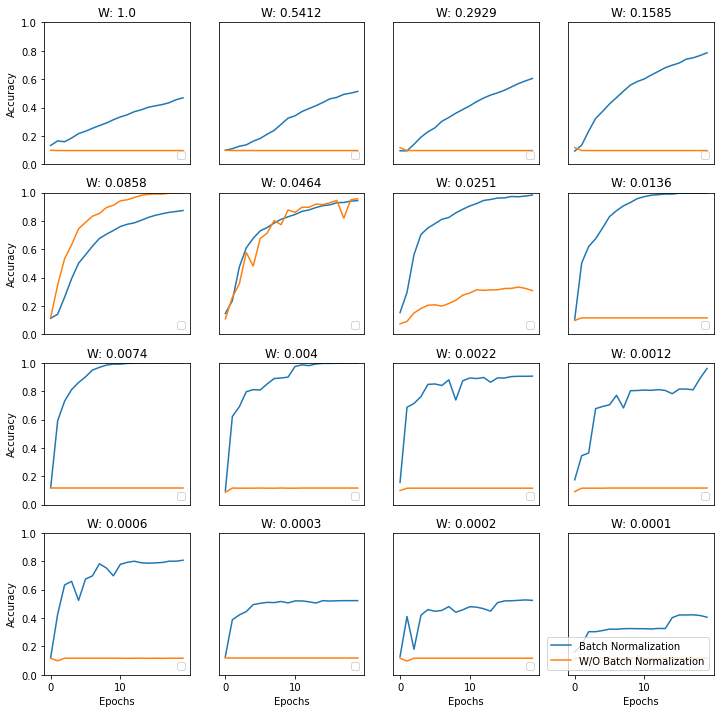

In [6]:
# graph
weight_scale_list = np.logspace(0, -4, num = 16)
x = np.arange(max_epochs)

plt.figure(figsize = (12, 12))

for i, w in enumerate(weight_scale_list):
    print("=" * 10 + " " + str(i + 1) + "/16" + " " + "=" * 10)
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4, 4, i + 1)
    plt.title("W: " + str(round(w, 4))) # W: multiplied to normalized
                                        # batch data
    if i == 15:
        plt.plot(x, bn_train_acc_list, label = "Batch Normalization",
                 markevery = 2)
        plt.plot(x, train_acc_list, label = "W/O Batch Normalization",
                 markevery = 2)
    else:
        plt.plot(x, bn_train_acc_list, markevery = 2)
        plt.plot(x, train_acc_list, markevery = 2)
        
    plt.ylim(0, 1.0)
    if i % 4: # True unless i = 0, False if i = 0.
        plt.yticks([])
    else:
        plt.ylabel("Accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("Epochs")
    plt.legend(loc = "lower right")
plt.show()

Optimizer: Adam

In [7]:
# input data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train[:1000].reshape(1000, 784)
t_train = t_train[:1000]
x_test = x_test.reshape(-1, 784)

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

In [8]:
def __train2(weight_init_std):
    # network w/ batch normalization
    bn_network = MultiLayerNetExtend(input_size = 784,
                                     hidden_size_list = [100, 100, 100, 100, 100],
                                     output_size = 10,
                                     weight_init_std = weight_init_std,
                                     use_batchnorm = True)
    # network w/o batch normalization
    network = MultiLayerNetExtend(input_size = 784,
                                  hidden_size_list = [100, 100, 100, 100, 100],
                                  output_size = 10,
                                  weight_init_std = weight_init_std,
                                  use_batchnorm = False)
    optimizer = Adam(lr = learning_rate)
    
    bn_train_acc_list = []
    train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
        
        if i % iter_per_epoch == 0:
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc_list.append(bn_train_acc)
            train_acc_list.append(train_acc)
            
            print("Epoch:\t" + str(epoch_cnt + 1) + "\t| " +\
                 str(round(train_acc, 3)) + " - " +\
                 str(round(bn_train_acc, 3)))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

========== 1/16 ==========
Epoch:	1	| 0.103 - 0.084
Epoch:	2	| 0.495 - 0.144
Epoch:	3	| 0.678 - 0.293
Epoch:	4	| 0.762 - 0.397
Epoch:	5	| 0.825 - 0.49
Epoch:	6	| 0.887 - 0.541
Epoch:	7	| 0.914 - 0.584
Epoch:	8	| 0.953 - 0.617
Epoch:	9	| 0.955 - 0.64
Epoch:	10	| 0.958 - 0.658
Epoch:	11	| 0.962 - 0.693
Epoch:	12	| 0.975 - 0.703
Epoch:	13	| 0.986 - 0.738
Epoch:	14	| 0.979 - 0.742
Epoch:	15	| 0.973 - 0.753
Epoch:	16	| 0.984 - 0.769
Epoch:	17	| 0.99 - 0.774
Epoch:	18	| 0.994 - 0.803


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.986 - 0.807
Epoch:	20	| 0.988 - 0.815
========== 2/16 ==========
Epoch:	1	| 0.119 - 0.136
Epoch:	2	| 0.451 - 0.208
Epoch:	3	| 0.674 - 0.333
Epoch:	4	| 0.795 - 0.412
Epoch:	5	| 0.831 - 0.489
Epoch:	6	| 0.892 - 0.554
Epoch:	7	| 0.91 - 0.599
Epoch:	8	| 0.944 - 0.653
Epoch:	9	| 0.945 - 0.67
Epoch:	10	| 0.959 - 0.718
Epoch:	11	| 0.97 - 0.731
Epoch:	12	| 0.986 - 0.75
Epoch:	13	| 0.979 - 0.78
Epoch:	14	| 0.979 - 0.793
Epoch:	15	| 0.987 - 0.812
Epoch:	16	| 0.983 - 0.822
Epoch:	17	| 0.979 - 0.831
Epoch:	18	| 0.98 - 0.845
Epoch:	19	| 0.98 - 0.856


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.987 - 0.86
========== 3/16 ==========
Epoch:	1	| 0.15 - 0.118
Epoch:	2	| 0.504 - 0.24
Epoch:	3	| 0.659 - 0.442
Epoch:	4	| 0.794 - 0.546
Epoch:	5	| 0.85 - 0.655
Epoch:	6	| 0.902 - 0.696
Epoch:	7	| 0.895 - 0.719
Epoch:	8	| 0.919 - 0.749
Epoch:	9	| 0.936 - 0.781
Epoch:	10	| 0.944 - 0.809
Epoch:	11	| 0.949 - 0.822
Epoch:	12	| 0.95 - 0.826
Epoch:	13	| 0.952 - 0.865
Epoch:	14	| 0.974 - 0.85
Epoch:	15	| 0.973 - 0.866
Epoch:	16	| 0.97 - 0.873
Epoch:	17	| 0.984 - 0.882
Epoch:	18	| 0.97 - 0.897


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.975 - 0.906
Epoch:	20	| 0.971 - 0.913
========== 4/16 ==========
Epoch:	1	| 0.126 - 0.148
Epoch:	2	| 0.457 - 0.327
Epoch:	3	| 0.594 - 0.561
Epoch:	4	| 0.741 - 0.722
Epoch:	5	| 0.82 - 0.799
Epoch:	6	| 0.856 - 0.835
Epoch:	7	| 0.886 - 0.865
Epoch:	8	| 0.888 - 0.906
Epoch:	9	| 0.899 - 0.92
Epoch:	10	| 0.929 - 0.938
Epoch:	11	| 0.934 - 0.952
Epoch:	12	| 0.94 - 0.968
Epoch:	13	| 0.956 - 0.98
Epoch:	14	| 0.939 - 0.987
Epoch:	15	| 0.92 - 0.982
Epoch:	16	| 0.952 - 0.988
Epoch:	17	| 0.97 - 0.997
Epoch:	18	| 0.958 - 0.993
Epoch:	19	| 0.957 - 0.997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.976 - 0.996
========== 5/16 ==========
Epoch:	1	| 0.128 - 0.125
Epoch:	2	| 0.464 - 0.431
Epoch:	3	| 0.693 - 0.798
Epoch:	4	| 0.791 - 0.915
Epoch:	5	| 0.888 - 0.939
Epoch:	6	| 0.925 - 0.966
Epoch:	7	| 0.926 - 0.977
Epoch:	8	| 0.949 - 0.989
Epoch:	9	| 0.956 - 0.99
Epoch:	10	| 0.883 - 0.999
Epoch:	11	| 0.904 - 0.987
Epoch:	12	| 0.925 - 0.994
Epoch:	13	| 0.954 - 0.992
Epoch:	14	| 0.952 - 0.993
Epoch:	15	| 0.962 - 0.997
Epoch:	16	| 0.966 - 0.996
Epoch:	17	| 0.96 - 0.994
Epoch:	18	| 0.97 - 0.996
Epoch:	19	| 0.965 - 0.997
Epoch:	20	| 0.961 - 0.995


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


========== 6/16 ==========
Epoch:	1	| 0.117 - 0.159
Epoch:	2	| 0.44 - 0.799
Epoch:	3	| 0.689 - 0.904
Epoch:	4	| 0.886 - 0.935
Epoch:	5	| 0.922 - 0.97
Epoch:	6	| 0.925 - 0.936
Epoch:	7	| 0.942 - 0.978
Epoch:	8	| 0.943 - 0.983
Epoch:	9	| 0.972 - 0.989
Epoch:	10	| 0.963 - 0.985
Epoch:	11	| 0.908 - 0.987
Epoch:	12	| 0.964 - 0.992
Epoch:	13	| 0.98 - 0.987
Epoch:	14	| 0.971 - 0.994
Epoch:	15	| 0.973 - 0.982
Epoch:	16	| 0.958 - 0.986
Epoch:	17	| 0.972 - 0.994
Epoch:	18	| 0.987 - 0.996
Epoch:	19	| 0.993 - 0.997
Epoch:	20	| 0.98 - 0.996


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


========== 7/16 ==========
Epoch:	1	| 0.094 - 0.088
Epoch:	2	| 0.462 - 0.775
Epoch:	3	| 0.693 - 0.885
Epoch:	4	| 0.876 - 0.929
Epoch:	5	| 0.944 - 0.94
Epoch:	6	| 0.924 - 0.975
Epoch:	7	| 0.955 - 0.974
Epoch:	8	| 0.961 - 0.975
Epoch:	9	| 0.973 - 0.984
Epoch:	10	| 0.953 - 0.988
Epoch:	11	| 0.934 - 0.989
Epoch:	12	| 0.942 - 0.984
Epoch:	13	| 0.966 - 0.986
Epoch:	14	| 0.937 - 0.986
Epoch:	15	| 0.968 - 0.994
Epoch:	16	| 0.986 - 0.983
Epoch:	17	| 0.987 - 0.995
Epoch:	18	| 0.965 - 0.99
Epoch:	19	| 0.988 - 0.994


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.986 - 0.996
========== 8/16 ==========
Epoch:	1	| 0.099 - 0.088
Epoch:	2	| 0.186 - 0.605
Epoch:	3	| 0.628 - 0.815
Epoch:	4	| 0.821 - 0.932
Epoch:	5	| 0.916 - 0.935
Epoch:	6	| 0.928 - 0.961
Epoch:	7	| 0.954 - 0.979
Epoch:	8	| 0.952 - 0.961
Epoch:	9	| 0.972 - 0.978
Epoch:	10	| 0.925 - 0.972
Epoch:	11	| 0.765 - 0.921
Epoch:	12	| 0.9 - 0.968
Epoch:	13	| 0.962 - 0.993
Epoch:	14	| 0.967 - 0.983
Epoch:	15	| 0.984 - 0.991
Epoch:	16	| 0.99 - 0.99
Epoch:	17	| 0.975 - 0.992
Epoch:	18	| 0.972 - 0.985


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.98 - 0.985
Epoch:	20	| 0.966 - 0.991
========== 9/16 ==========
Epoch:	1	| 0.097 - 0.08
Epoch:	2	| 0.371 - 0.431
Epoch:	3	| 0.592 - 0.726
Epoch:	4	| 0.721 - 0.9
Epoch:	5	| 0.803 - 0.927
Epoch:	6	| 0.926 - 0.892
Epoch:	7	| 0.892 - 0.933
Epoch:	8	| 0.949 - 0.968
Epoch:	9	| 0.95 - 0.976
Epoch:	10	| 0.96 - 0.983
Epoch:	11	| 0.973 - 0.983
Epoch:	12	| 0.978 - 0.981
Epoch:	13	| 0.978 - 0.99
Epoch:	14	| 0.93 - 0.984
Epoch:	15	| 0.975 - 0.992
Epoch:	16	| 0.967 - 0.991
Epoch:	17	| 0.934 - 0.992
Epoch:	18	| 0.908 - 0.971
Epoch:	19	| 0.962 - 0.961


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.97 - 0.983
========== 10/16 ==========
Epoch:	1	| 0.105 - 0.105
Epoch:	2	| 0.516 - 0.473
Epoch:	3	| 0.716 - 0.807
Epoch:	4	| 0.896 - 0.912
Epoch:	5	| 0.921 - 0.946
Epoch:	6	| 0.909 - 0.949
Epoch:	7	| 0.903 - 0.962
Epoch:	8	| 0.942 - 0.971
Epoch:	9	| 0.948 - 0.961
Epoch:	10	| 0.952 - 0.973
Epoch:	11	| 0.962 - 0.969
Epoch:	12	| 0.966 - 0.984
Epoch:	13	| 0.935 - 0.986
Epoch:	14	| 0.959 - 0.986
Epoch:	15	| 0.97 - 0.988
Epoch:	16	| 0.984 - 0.992
Epoch:	17	| 0.973 - 0.992
Epoch:	18	| 0.971 - 0.997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.891 - 0.978
Epoch:	20	| 0.975 - 0.995
========== 11/16 ==========
Epoch:	1	| 0.105 - 0.093
Epoch:	2	| 0.329 - 0.479
Epoch:	3	| 0.643 - 0.745
Epoch:	4	| 0.837 - 0.879
Epoch:	5	| 0.878 - 0.906
Epoch:	6	| 0.938 - 0.961
Epoch:	7	| 0.931 - 0.954
Epoch:	8	| 0.939 - 0.961
Epoch:	9	| 0.93 - 0.95
Epoch:	10	| 0.933 - 0.972
Epoch:	11	| 0.962 - 0.988
Epoch:	12	| 0.974 - 0.984
Epoch:	13	| 0.98 - 0.993
Epoch:	14	| 0.975 - 0.994
Epoch:	15	| 0.962 - 0.997
Epoch:	16	| 0.987 - 0.995
Epoch:	17	| 0.977 - 0.989
Epoch:	18	| 0.955 - 0.98
Epoch:	19	| 0.971 - 0.994


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.953 - 0.974
========== 12/16 ==========
Epoch:	1	| 0.117 - 0.102
Epoch:	2	| 0.468 - 0.475
Epoch:	3	| 0.612 - 0.685
Epoch:	4	| 0.792 - 0.821
Epoch:	5	| 0.815 - 0.887
Epoch:	6	| 0.912 - 0.931
Epoch:	7	| 0.929 - 0.942
Epoch:	8	| 0.932 - 0.963
Epoch:	9	| 0.948 - 0.972
Epoch:	10	| 0.967 - 0.959
Epoch:	11	| 0.972 - 0.986
Epoch:	12	| 0.98 - 0.98
Epoch:	13	| 0.946 - 0.947
Epoch:	14	| 0.965 - 0.988
Epoch:	15	| 0.943 - 0.91
Epoch:	16	| 0.953 - 0.945
Epoch:	17	| 0.958 - 0.981
Epoch:	18	| 0.985 - 0.993


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	19	| 0.969 - 0.99
Epoch:	20	| 0.96 - 0.981
========== 13/16 ==========
Epoch:	1	| 0.084 - 0.103
Epoch:	2	| 0.333 - 0.422
Epoch:	3	| 0.498 - 0.662
Epoch:	4	| 0.782 - 0.875
Epoch:	5	| 0.807 - 0.897
Epoch:	6	| 0.782 - 0.844
Epoch:	7	| 0.748 - 0.889
Epoch:	8	| 0.902 - 0.94
Epoch:	9	| 0.927 - 0.969
Epoch:	10	| 0.968 - 0.981
Epoch:	11	| 0.968 - 0.981
Epoch:	12	| 0.953 - 0.986
Epoch:	13	| 0.955 - 0.992
Epoch:	14	| 0.961 - 0.99
Epoch:	15	| 0.966 - 0.991
Epoch:	16	| 0.97 - 0.986
Epoch:	17	| 0.979 - 0.984
Epoch:	18	| 0.981 - 0.998
Epoch:	19	| 0.991 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.923 - 0.976
========== 14/16 ==========
Epoch:	1	| 0.097 - 0.078
Epoch:	2	| 0.351 - 0.486
Epoch:	3	| 0.657 - 0.612
Epoch:	4	| 0.788 - 0.863
Epoch:	5	| 0.89 - 0.921
Epoch:	6	| 0.914 - 0.948
Epoch:	7	| 0.938 - 0.938
Epoch:	8	| 0.925 - 0.967
Epoch:	9	| 0.933 - 0.973
Epoch:	10	| 0.947 - 0.978
Epoch:	11	| 0.978 - 0.981
Epoch:	12	| 0.936 - 0.965
Epoch:	13	| 0.965 - 0.989
Epoch:	14	| 0.975 - 0.993
Epoch:	15	| 0.966 - 0.968
Epoch:	16	| 0.972 - 0.993
Epoch:	17	| 0.954 - 0.981
Epoch:	18	| 0.981 - 0.994
Epoch:	19	| 0.971 - 0.995


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.949 - 0.987
========== 15/16 ==========
Epoch:	1	| 0.1 - 0.119
Epoch:	2	| 0.222 - 0.324
Epoch:	3	| 0.424 - 0.816
Epoch:	4	| 0.495 - 0.855
Epoch:	5	| 0.779 - 0.808
Epoch:	6	| 0.909 - 0.941
Epoch:	7	| 0.935 - 0.966
Epoch:	8	| 0.888 - 0.95
Epoch:	9	| 0.959 - 0.976
Epoch:	10	| 0.961 - 0.986
Epoch:	11	| 0.933 - 0.933
Epoch:	12	| 0.966 - 0.981
Epoch:	13	| 0.98 - 0.991
Epoch:	14	| 0.976 - 0.983
Epoch:	15	| 0.977 - 0.996
Epoch:	16	| 0.992 - 0.995
Epoch:	17	| 0.991 - 0.996
Epoch:	18	| 0.987 - 0.989
Epoch:	19	| 0.989 - 0.988
Epoch:	20	| 0.948 - 0.972


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


========== 16/16 ==========
Epoch:	1	| 0.087 - 0.105
Epoch:	2	| 0.41 - 0.459
Epoch:	3	| 0.616 - 0.765
Epoch:	4	| 0.706 - 0.901
Epoch:	5	| 0.668 - 0.835
Epoch:	6	| 0.909 - 0.929
Epoch:	7	| 0.906 - 0.95
Epoch:	8	| 0.821 - 0.935
Epoch:	9	| 0.858 - 0.966
Epoch:	10	| 0.929 - 0.973
Epoch:	11	| 0.884 - 0.933
Epoch:	12	| 0.953 - 0.965
Epoch:	13	| 0.948 - 0.977
Epoch:	14	| 0.94 - 0.985
Epoch:	15	| 0.97 - 0.994
Epoch:	16	| 0.983 - 0.99
Epoch:	17	| 0.982 - 0.997
Epoch:	18	| 0.989 - 0.998
Epoch:	19	| 0.983 - 0.994
Epoch:	20	| 0.984 - 0.996


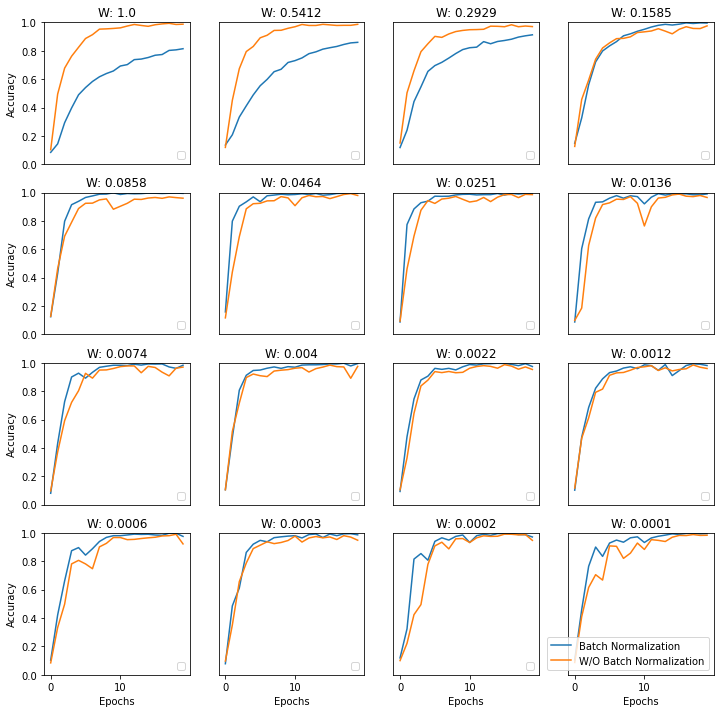

In [9]:
# graph
weight_scale_list = np.logspace(0, -4, num = 16)
x = np.arange(max_epochs)

plt.figure(figsize = (12, 12))

for i, w in enumerate(weight_scale_list):
    print("=" * 10 + " " + str(i + 1) + "/16" + " " + "=" * 10)
    train_acc_list, bn_train_acc_list = __train2(w)
    
    plt.subplot(4, 4, i + 1)
    plt.title("W: " + str(round(w, 4))) # W: multiplied to normalized
                                        # batch data
    if i == 15:
        plt.plot(x, bn_train_acc_list, label = "Batch Normalization",
                 markevery = 2)
        plt.plot(x, train_acc_list, label = "W/O Batch Normalization",
                 markevery = 2)
    else:
        plt.plot(x, bn_train_acc_list, markevery = 2)
        plt.plot(x, train_acc_list, markevery = 2)
        
    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("Accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("Epochs")
    plt.legend(loc = "lower right")
plt.show()

Optimizer: Adam <br>
Input Data Modified <br>
Weight Scale List Modified

In the case in which Adam optimizer is applied and the size of data is increased (but without Batch Normalization), it shows worse performance than the approach which adopts SGD optimizer and Batch Normalization. <br>
<br>
This additional experiment shows that we need to apply Batch Normalization to obtain better deep neural networks.

In [10]:
# input data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)


max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

========== 1/16 ==========
Epoch:	1	| 0.107 - 0.151
Epoch:	2	| 0.852 - 0.756
Epoch:	3	| 0.866 - 0.827
Epoch:	4	| 0.889 - 0.852
Epoch:	5	| 0.901 - 0.867
Epoch:	6	| 0.882 - 0.871
Epoch:	7	| 0.894 - 0.874
Epoch:	8	| 0.885 - 0.879
Epoch:	9	| 0.888 - 0.883
Epoch:	10	| 0.88 - 0.887
Epoch:	11	| 0.829 - 0.887
Epoch:	12	| 0.864 - 0.887
Epoch:	13	| 0.736 - 0.884
Epoch:	14	| 0.214 - 0.888
Epoch:	15	| 0.148 - 0.892
Epoch:	16	| 0.149 - 0.892
Epoch:	17	| 0.112 - 0.898
Epoch:	18	| 0.107 - 0.902
Epoch:	19	| 0.105 - 0.906


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:	20	| 0.112 - 0.913


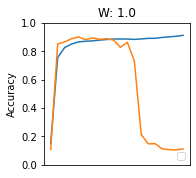

In [11]:
# graph
weight_scale_list = np.logspace(0, -4, num = 1)
x = np.arange(max_epochs)

plt.figure(figsize = (12, 12))

for i, w in enumerate(weight_scale_list):
    print("=" * 10 + " " + str(i + 1) + "/16" + " " + "=" * 10)
    train_acc_list, bn_train_acc_list = __train2(w)
    
    plt.subplot(4, 4, i + 1)
    plt.title("W: " + str(round(w, 4))) # W: multiplied to normalized
                                        # batch data
    if i == 15:
        plt.plot(x, bn_train_acc_list, label = "Batch Normalization",
                 markevery = 2)
        plt.plot(x, train_acc_list, label = "W/O Batch Normalization",
                 markevery = 2)
    else:
        plt.plot(x, bn_train_acc_list, markevery = 2)
        plt.plot(x, train_acc_list, markevery = 2)
        
    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("Accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("Epochs")
    plt.legend(loc = "lower right")
plt.show()

# Back Propagation Check
---

Back Propagation is too complicated so that it is likely to have incorrect parts. So, compare its results to those from numerical gradients.

In [12]:
# input data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

network = MultiLayerNetExtend(input_size = 784,
                              hidden_size_list = [100, 100],
                              output_size = 10, use_batchnorm = True)

x_batch = x_train[:5].reshape(5, 784)
t_batch = t_train[:5]

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":\t" + str(round(diff, 2)))

# Since numerical gradients always have errors,
# they are slightly different from the results derived from back propagation.

W1:	0.0
b1:	0.0
gamma1:	0.0
beta1:	0.0
W2:	0.0
b2:	0.0
gamma2:	0.0
beta2:	0.0
W3:	0.0
b3:	0.0
